In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection
import pickle

In [2]:
class LayeredNetworkGraph(object):

    def __init__(self, graphs, node_labels=None, layout=nx.spring_layout, ax=None):
        
        """
        Code from: https://stackoverflow.com/questions/60392940/multi-layer-graph-in-networkx
        
        Given an ordered list of graphs [g1, g2, ..., gn] that represent
        different layers in a multi-layer network, plot the network in
        3D with the different layers separated along the z-axis.

        Within a layer, the corresponding graph defines the connectivity.
        Between layers, nodes in subsequent layers are connected if
        they have the same node ID.

        Arguments:
        ----------
        graphs : list of networkx.Graph objects
            List of graphs, one for each layer.

        node_labels : dict node ID : str label or None (default None)
            Dictionary mapping nodes to labels.
            If None is provided, nodes are not labelled.

        layout_func : function handle (default networkx.spring_layout)
            Function used to compute the layout.

        ax : mpl_toolkits.mplot3d.Axes3d instance or None (default None)
            The axis to plot to. If None is given, a new figure and a new axis are created.
            
        """

        # book-keeping
        self.graphs = graphs
        self.total_layers = len(graphs)

        self.node_labels = node_labels
        self.layout = layout

        if ax:
            self.ax = ax
        else:
            fig = plt.figure()
            self.ax = fig.add_subplot(111, projection='3d')

        # create internal representation of nodes and edges
        self.get_nodes()
        self.get_edges_within_layers()
        self.get_edges_between_layers()

        # compute layout and plot
        self.get_node_positions()
        self.draw()


    def get_nodes(self):
        """Construct an internal representation of nodes with the format (node ID, layer)."""
        self.nodes = []
        for z, g in enumerate(self.graphs):
            self.nodes.extend([(node, z) for node in g.nodes()])


    def get_edges_within_layers(self):
        """Remap edges in the individual layers to the internal representations of the node IDs."""
        self.edges_within_layers = []
        for z, g in enumerate(self.graphs):
            self.edges_within_layers.extend([((source, z), (target, z)) for source, target in g.edges()])


    def get_edges_between_layers(self):
        """Determine edges between layers. Nodes in subsequent layers are
        thought to be connected if they have the same ID."""
        self.edges_between_layers = []
        for z1, g in enumerate(self.graphs[:-1]):
            z2 = z1 + 1
            h = self.graphs[z2]
            shared_nodes = set(g.nodes()) & set(h.nodes())
            self.edges_between_layers.extend([((node, z1), (node, z2)) for node in shared_nodes])


    def get_node_positions(self, *args, **kwargs):
        """Get the node positions in the layered layout."""
        # What we would like to do, is apply the layout function to a combined, layered network.
        # However, networkx layout functions are not implemented for the multi-dimensional case.
        # Futhermore, even if there was such a layout function, there probably would be no straightforward way to
        # specify the planarity requirement for nodes within a layer.
        # Therefor, we compute the layout for the full network in 2D, and then apply the
        # positions to the nodes in all planes.
        # For a force-directed layout, this will approximately do the right thing.
        # TODO: implement FR in 3D with layer constraints.

        composition = self.graphs[0]
        for h in self.graphs[1:]:
            composition = nx.compose(composition, h)

        pos = self.layout(composition, *args, **kwargs)

        self.node_positions = dict()
        for z, g in enumerate(self.graphs):
            self.node_positions.update({(node, z) : (*pos[node], z) for node in g.nodes()})


    def draw_nodes(self, nodes, *args, **kwargs):
        x, y, z = zip(*[self.node_positions[node] for node in nodes])
        self.ax.scatter(x, y, z, *args, **kwargs)


    def draw_edges(self, edges, *args, **kwargs):
        segments = [(self.node_positions[source], self.node_positions[target]) for source, target in edges]
        line_collection = Line3DCollection(segments, *args, **kwargs)
        self.ax.add_collection3d(line_collection)


    def get_extent(self, pad=0.1):
        xyz = np.array(list(self.node_positions.values()))
        xmin, ymin, _ = np.min(xyz, axis=0)
        xmax, ymax, _ = np.max(xyz, axis=0)
        dx = xmax - xmin
        dy = ymax - ymin
        return (xmin - pad * dx, xmax + pad * dx), \
            (ymin - pad * dy, ymax + pad * dy)


    def draw_plane(self, z, *args, **kwargs):
        (xmin, xmax), (ymin, ymax) = self.get_extent(pad=0.1)
        u = np.linspace(xmin, xmax, 10)
        v = np.linspace(ymin, ymax, 10)
        U, V = np.meshgrid(u ,v)
        W = z * np.ones_like(U)
        self.ax.plot_surface(U, V, W, *args, **kwargs)


    def draw_node_labels(self, node_labels, *args, **kwargs):
        for node, z in self.nodes:
            if node in node_labels:
                ax.text(*self.node_positions[(node, z)], node_labels[node], *args, **kwargs)


    def draw(self):

        self.draw_edges(self.edges_within_layers,  color='k', alpha=0.3, linestyle='-', zorder=2)
        self.draw_edges(self.edges_between_layers, color='k', alpha=0.3, linestyle='--', zorder=2)

        for z in range(self.total_layers):
            self.draw_plane(z, alpha=0.2, zorder=1)
            self.draw_nodes([node for node in self.nodes if node[1]==z], s=300, zorder=3)

        if self.node_labels:
            self.draw_node_labels(self.node_labels,
                                  horizontalalignment='center',
                                  verticalalignment='center',
                                  zorder=100)



In [18]:
with open("networkx_graphs/layers/bert_layer_90_cos_thresh_nx_12-14_05:42.pickle", "rb") as input_file:
    bert_layer_nx = pickle.load(input_file)

In [19]:
with open("networkx_graphs/layers/visual_layer_90_cos_thresh_nx_12-14_05:42.pickle", "rb") as input_file:
    visual_layer_nx = pickle.load(input_file)

In [20]:
with open("networkx_graphs/layers/lancaster_layer_90_cos_thresh_nx_12-14_05:42.pickle", "rb") as input_file:
    lancaster_layer_nx = pickle.load(input_file)

In [21]:
with open("networkx_graphs/layers/free_association_layer_90_cos_thresh_nx_12-14_05:42.pickle", "rb") as input_file:
    free_association_layer_nx = pickle.load(input_file)

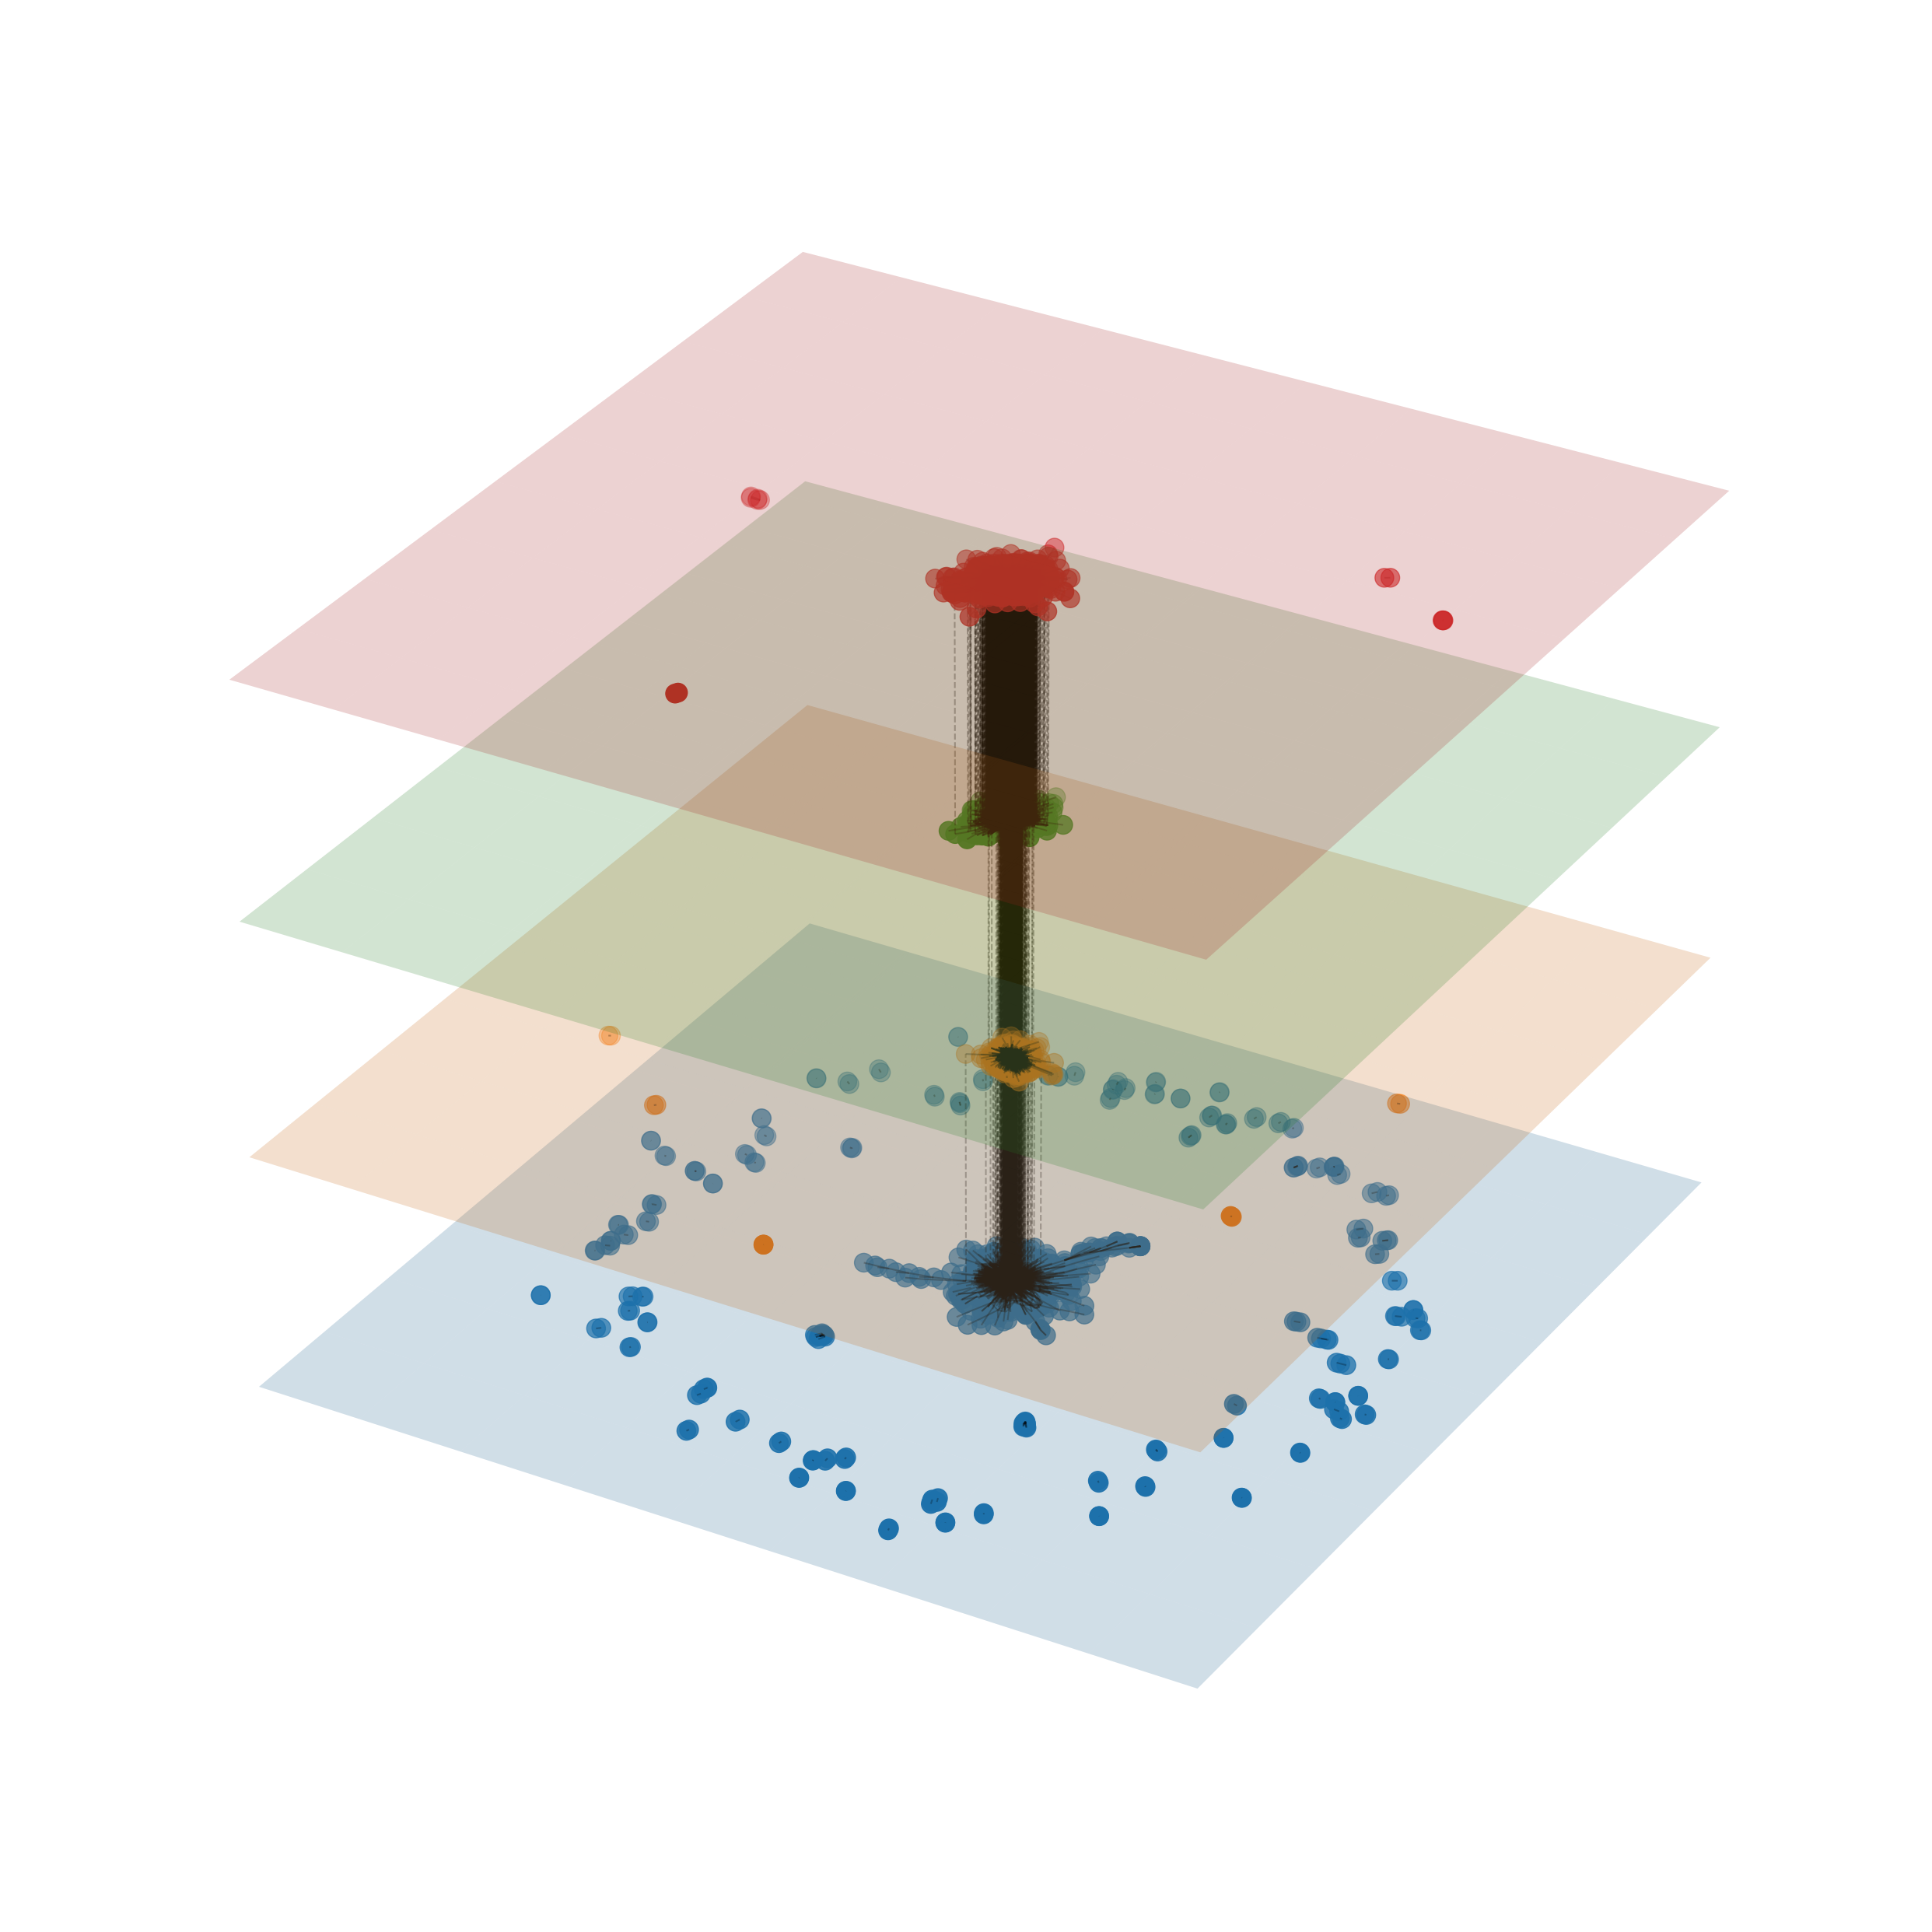

In [21]:

# define graphs
graph_layers = [bert_layer_nx, visual_layer_nx, lancaster_layer_nx, free_association_layer_nx]


node_labels = None
figsize = (40,32)
# initialise figure and plot
fig = plt.figure(figsize=(figsize))
ax = fig.add_subplot(111, projection='3d')
LayeredNetworkGraph(graph_layers, node_labels=node_labels, ax=ax, layout=nx.spring_layout)
ax.set_axis_off()
plt.show()

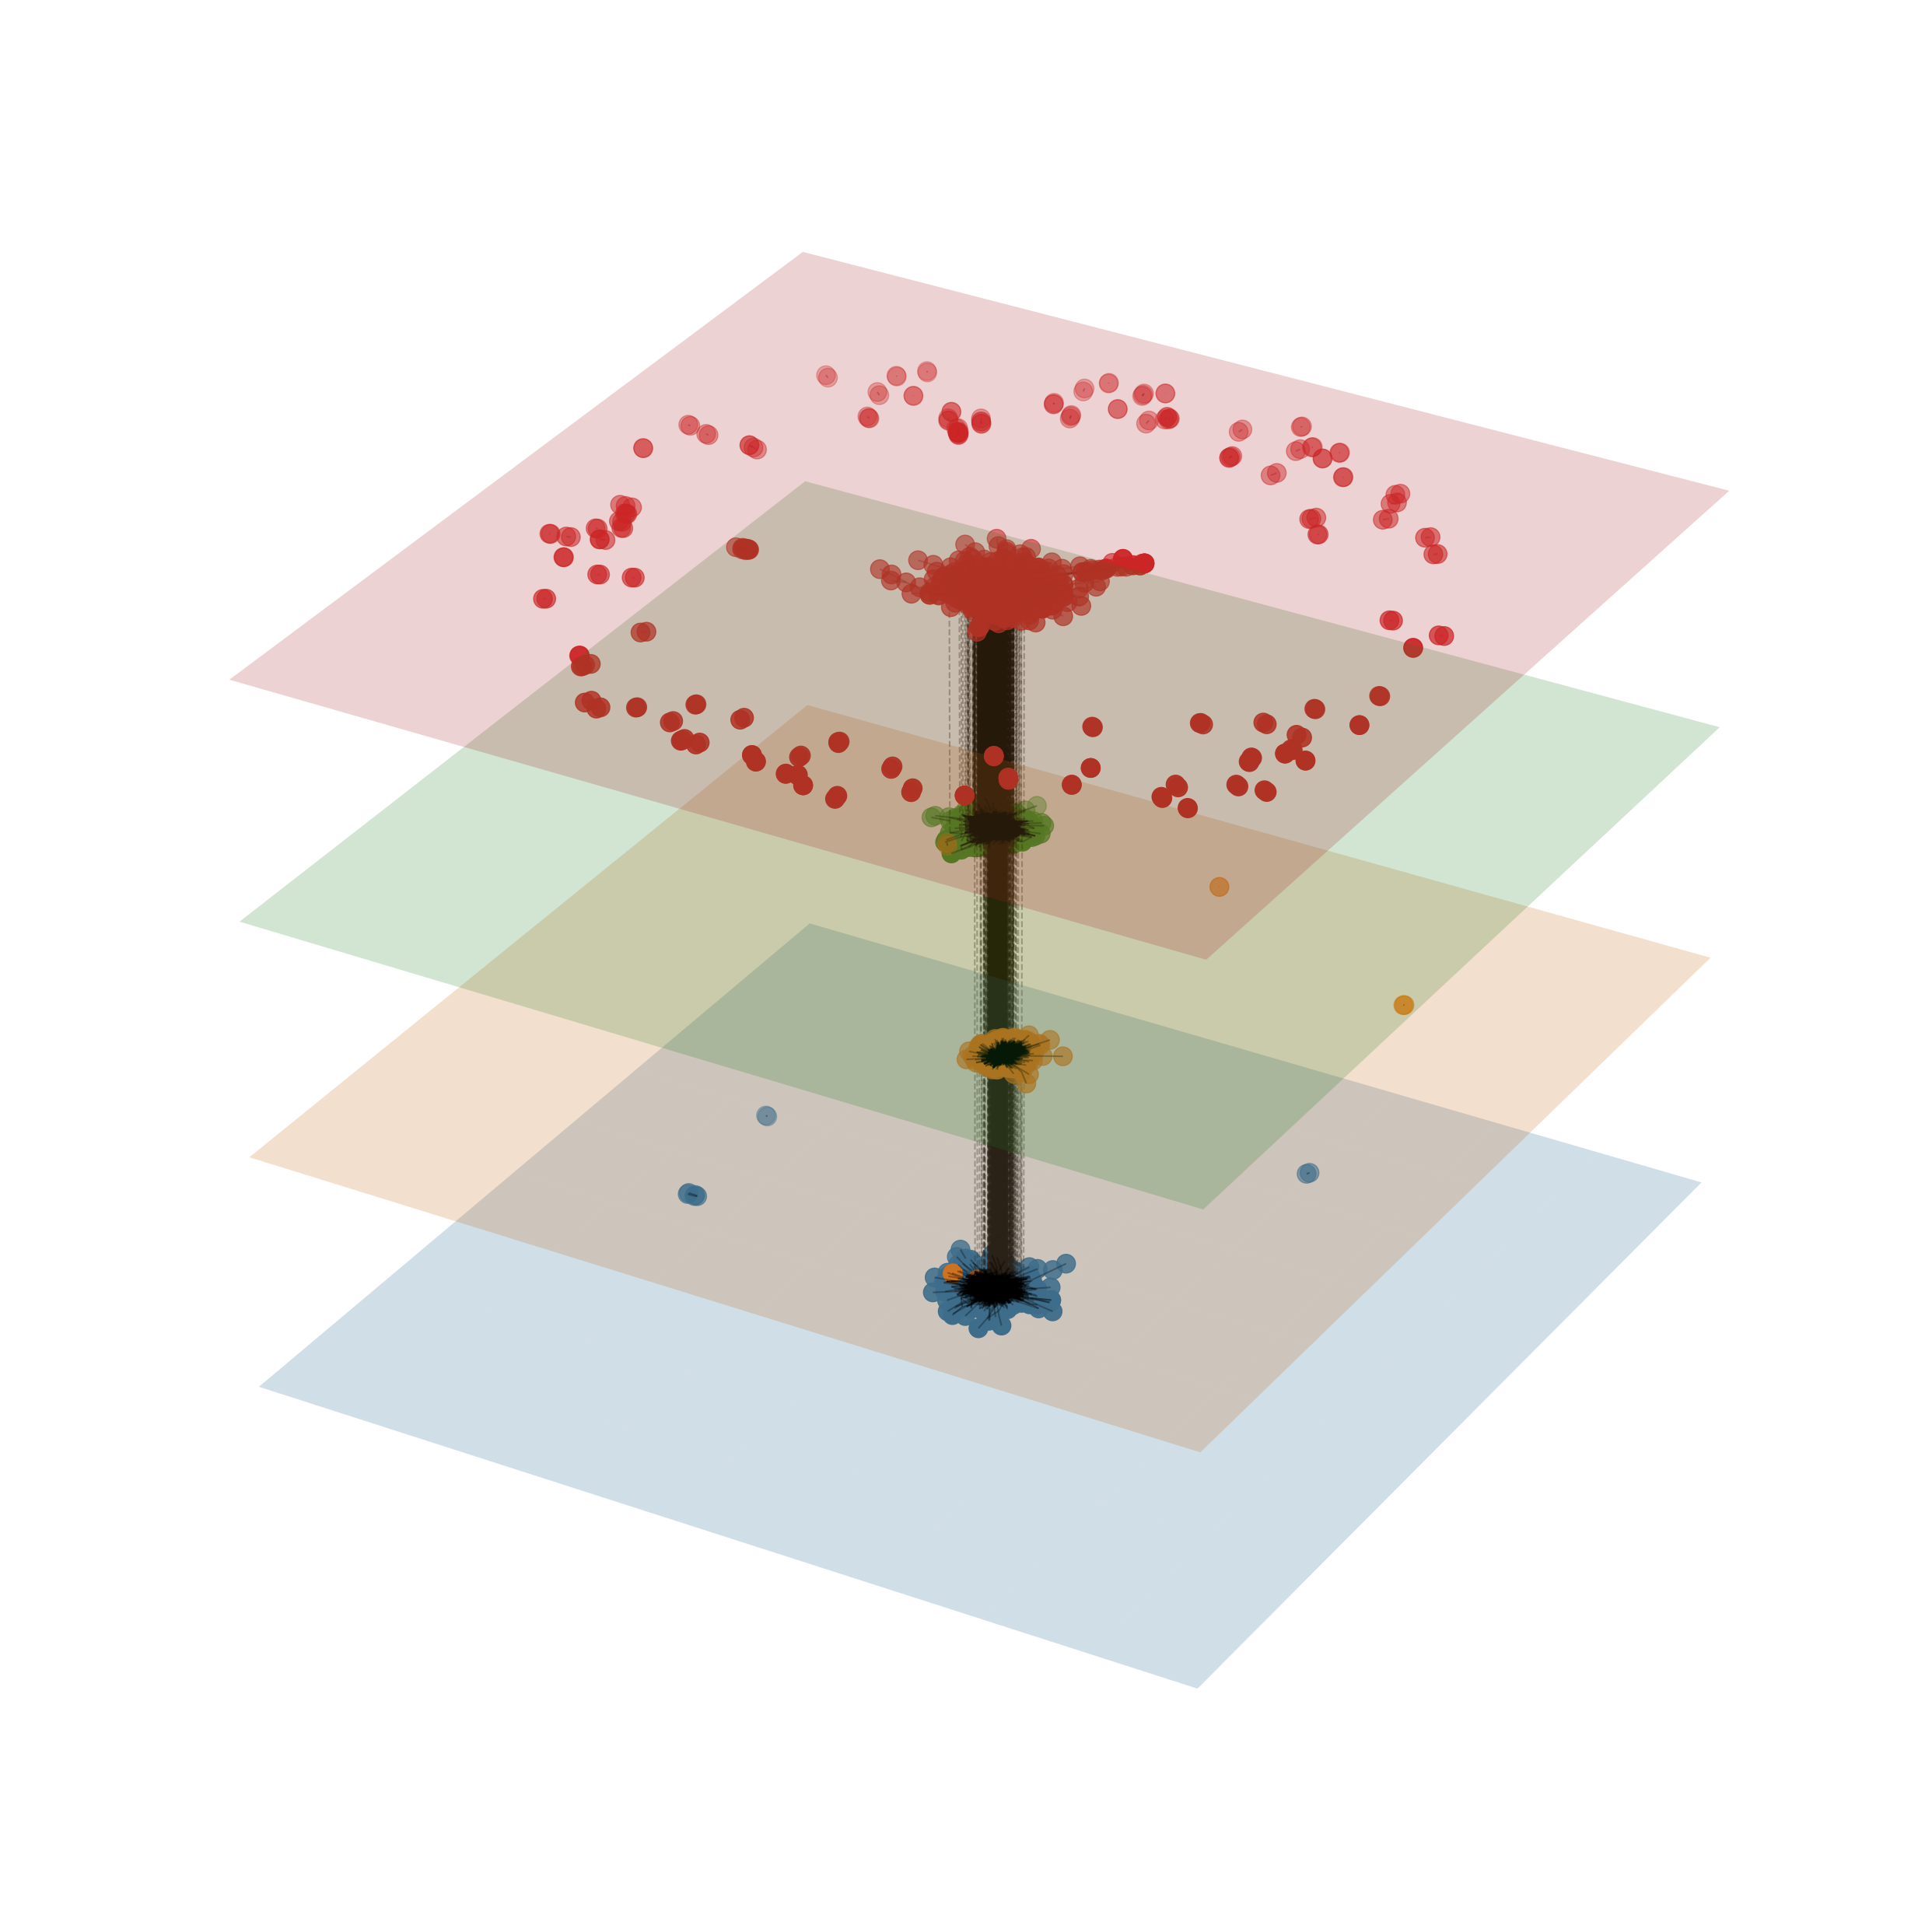

In [22]:

# define graphs
graph_layers = [free_association_layer_nx, visual_layer_nx, lancaster_layer_nx, bert_layer_nx]


node_labels = None
figsize = (40,32)
# initialise figure and plot
fig = plt.figure(figsize=(figsize))
ax = fig.add_subplot(111, projection='3d')
LayeredNetworkGraph(graph_layers, node_labels=node_labels, ax=ax, layout=nx.spring_layout)
ax.set_axis_off()
plt.show()

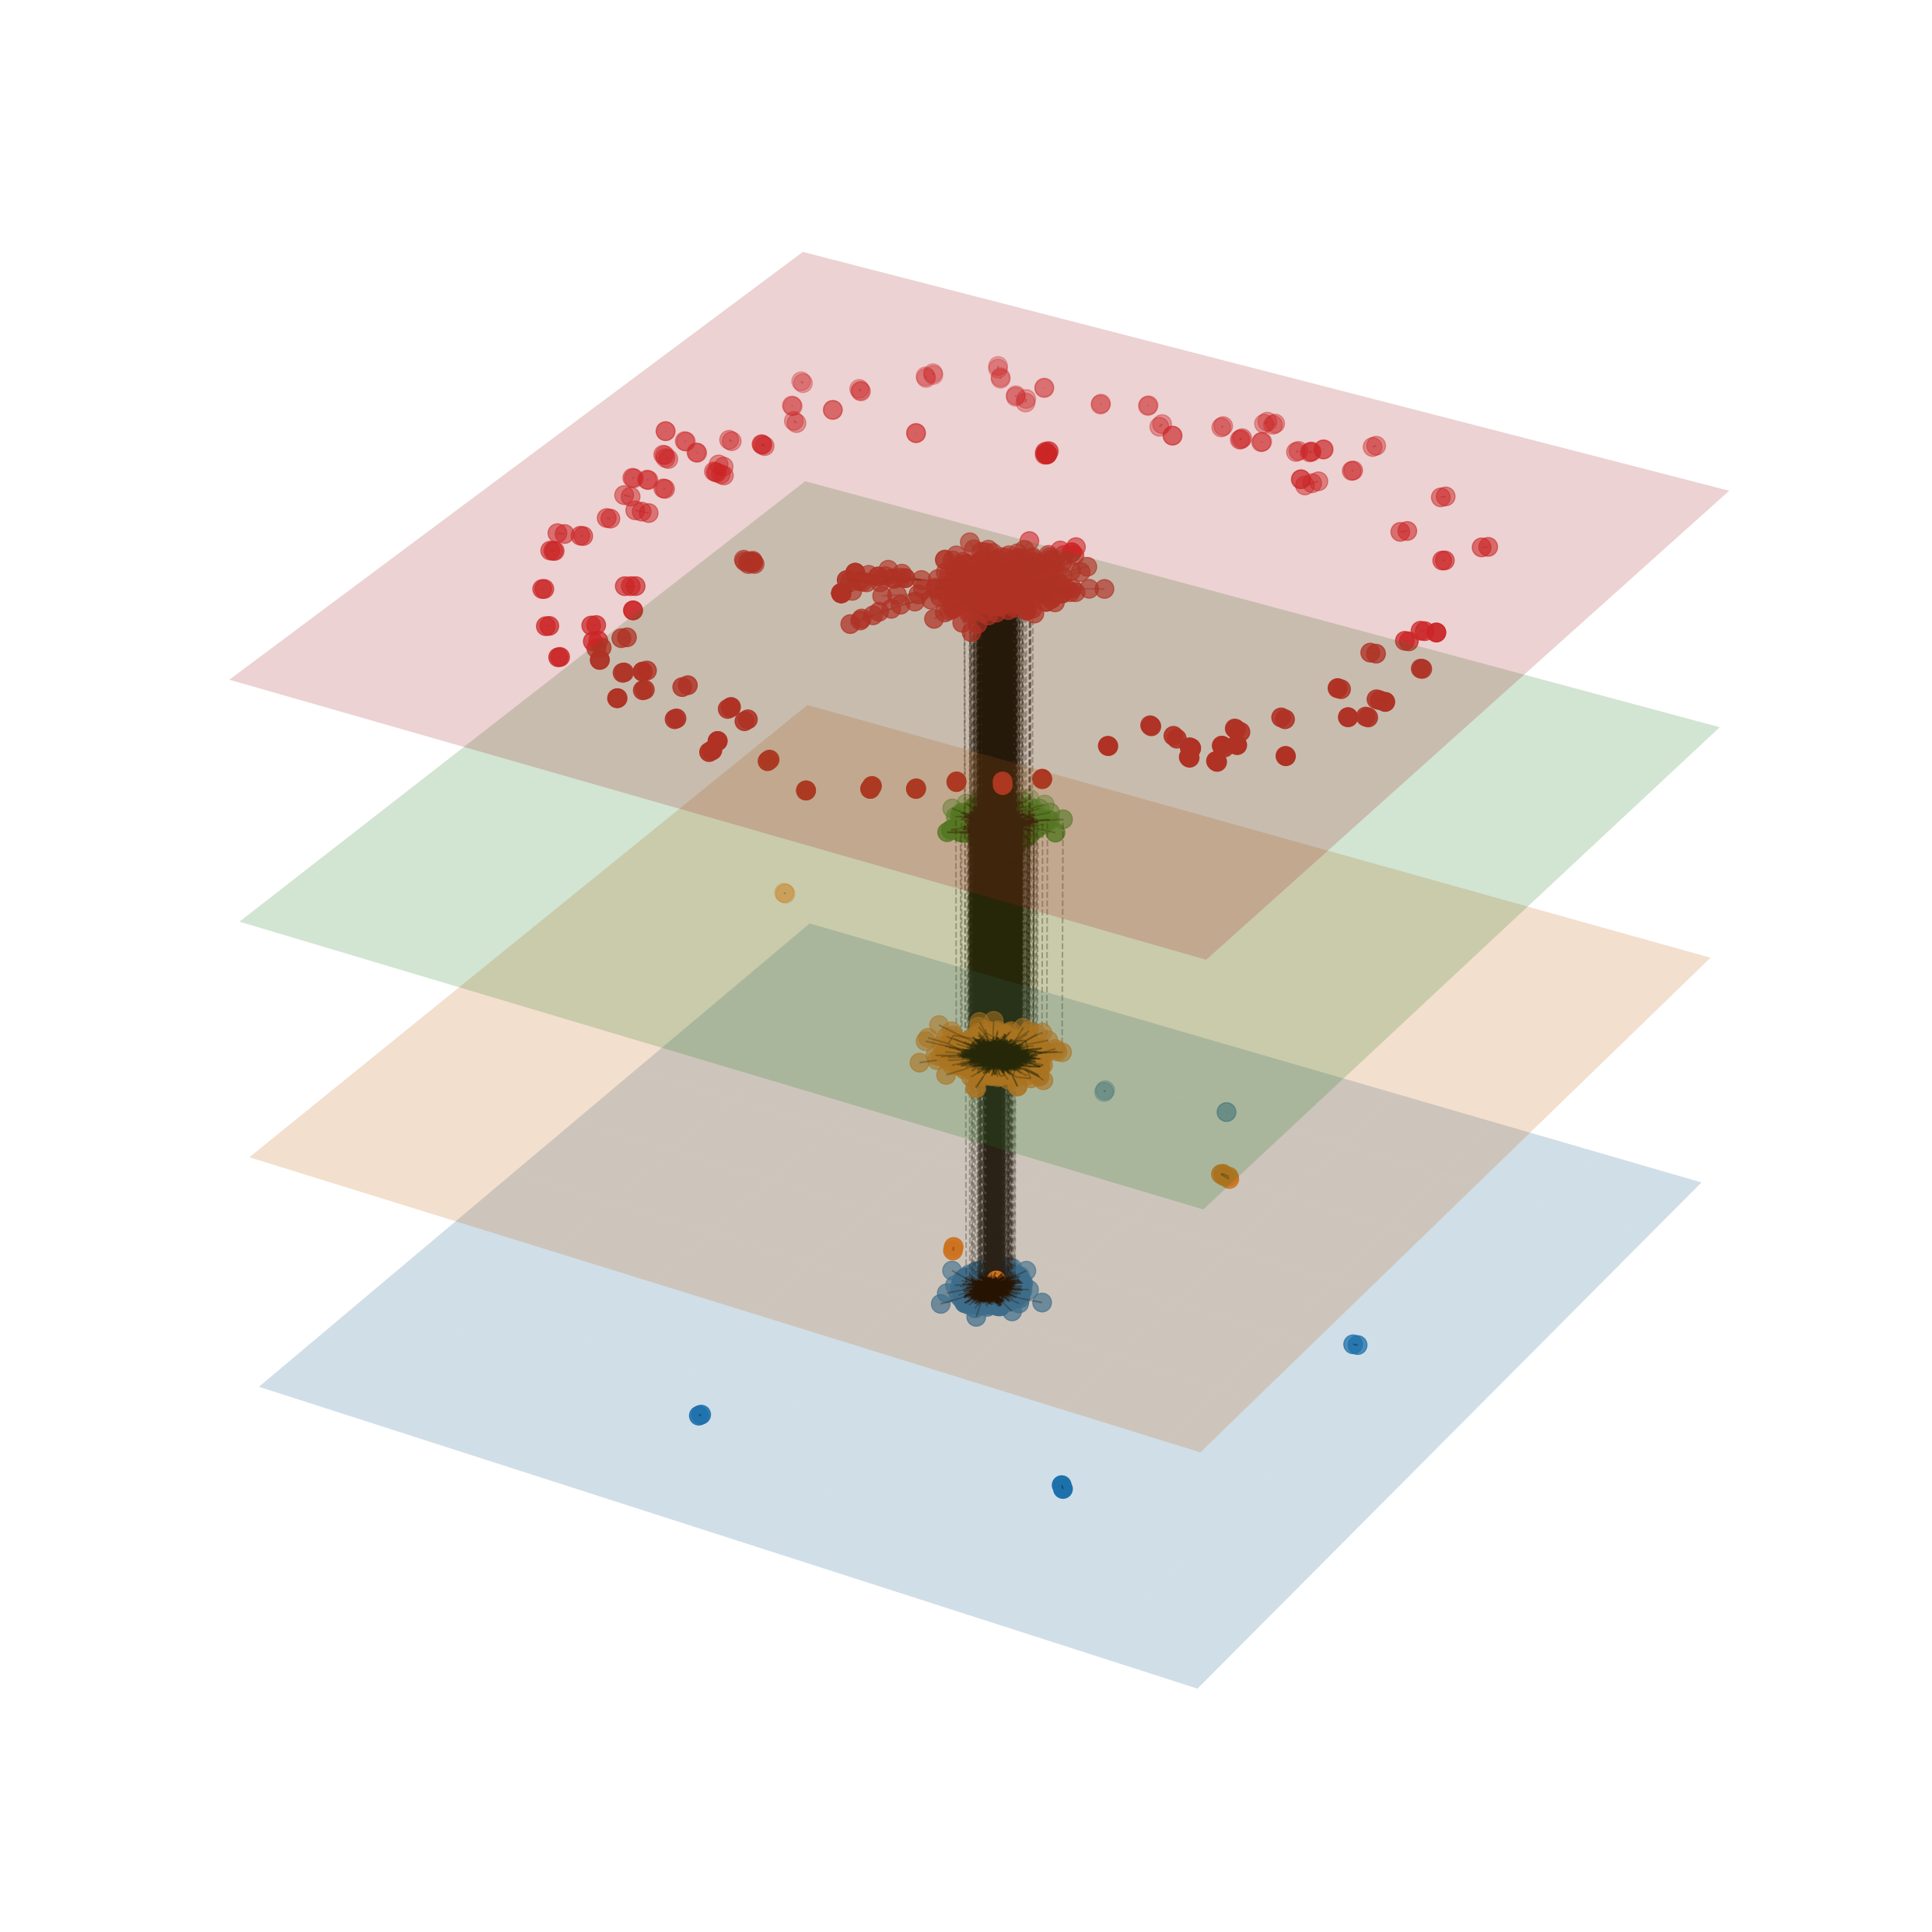

In [28]:

# define graphs
graph_layers = [visual_layer_nx, free_association_layer_nx, lancaster_layer_nx, bert_layer_nx]


node_labels = None
figsize = (40,32)
# initialise figure and plot
fig = plt.figure(figsize=(figsize))
ax = fig.add_subplot(111, projection='3d')
LayeredNetworkGraph(graph_layers, node_labels=node_labels, ax=ax, layout=nx.spring_layout)
ax.set_axis_off()
plt.show()

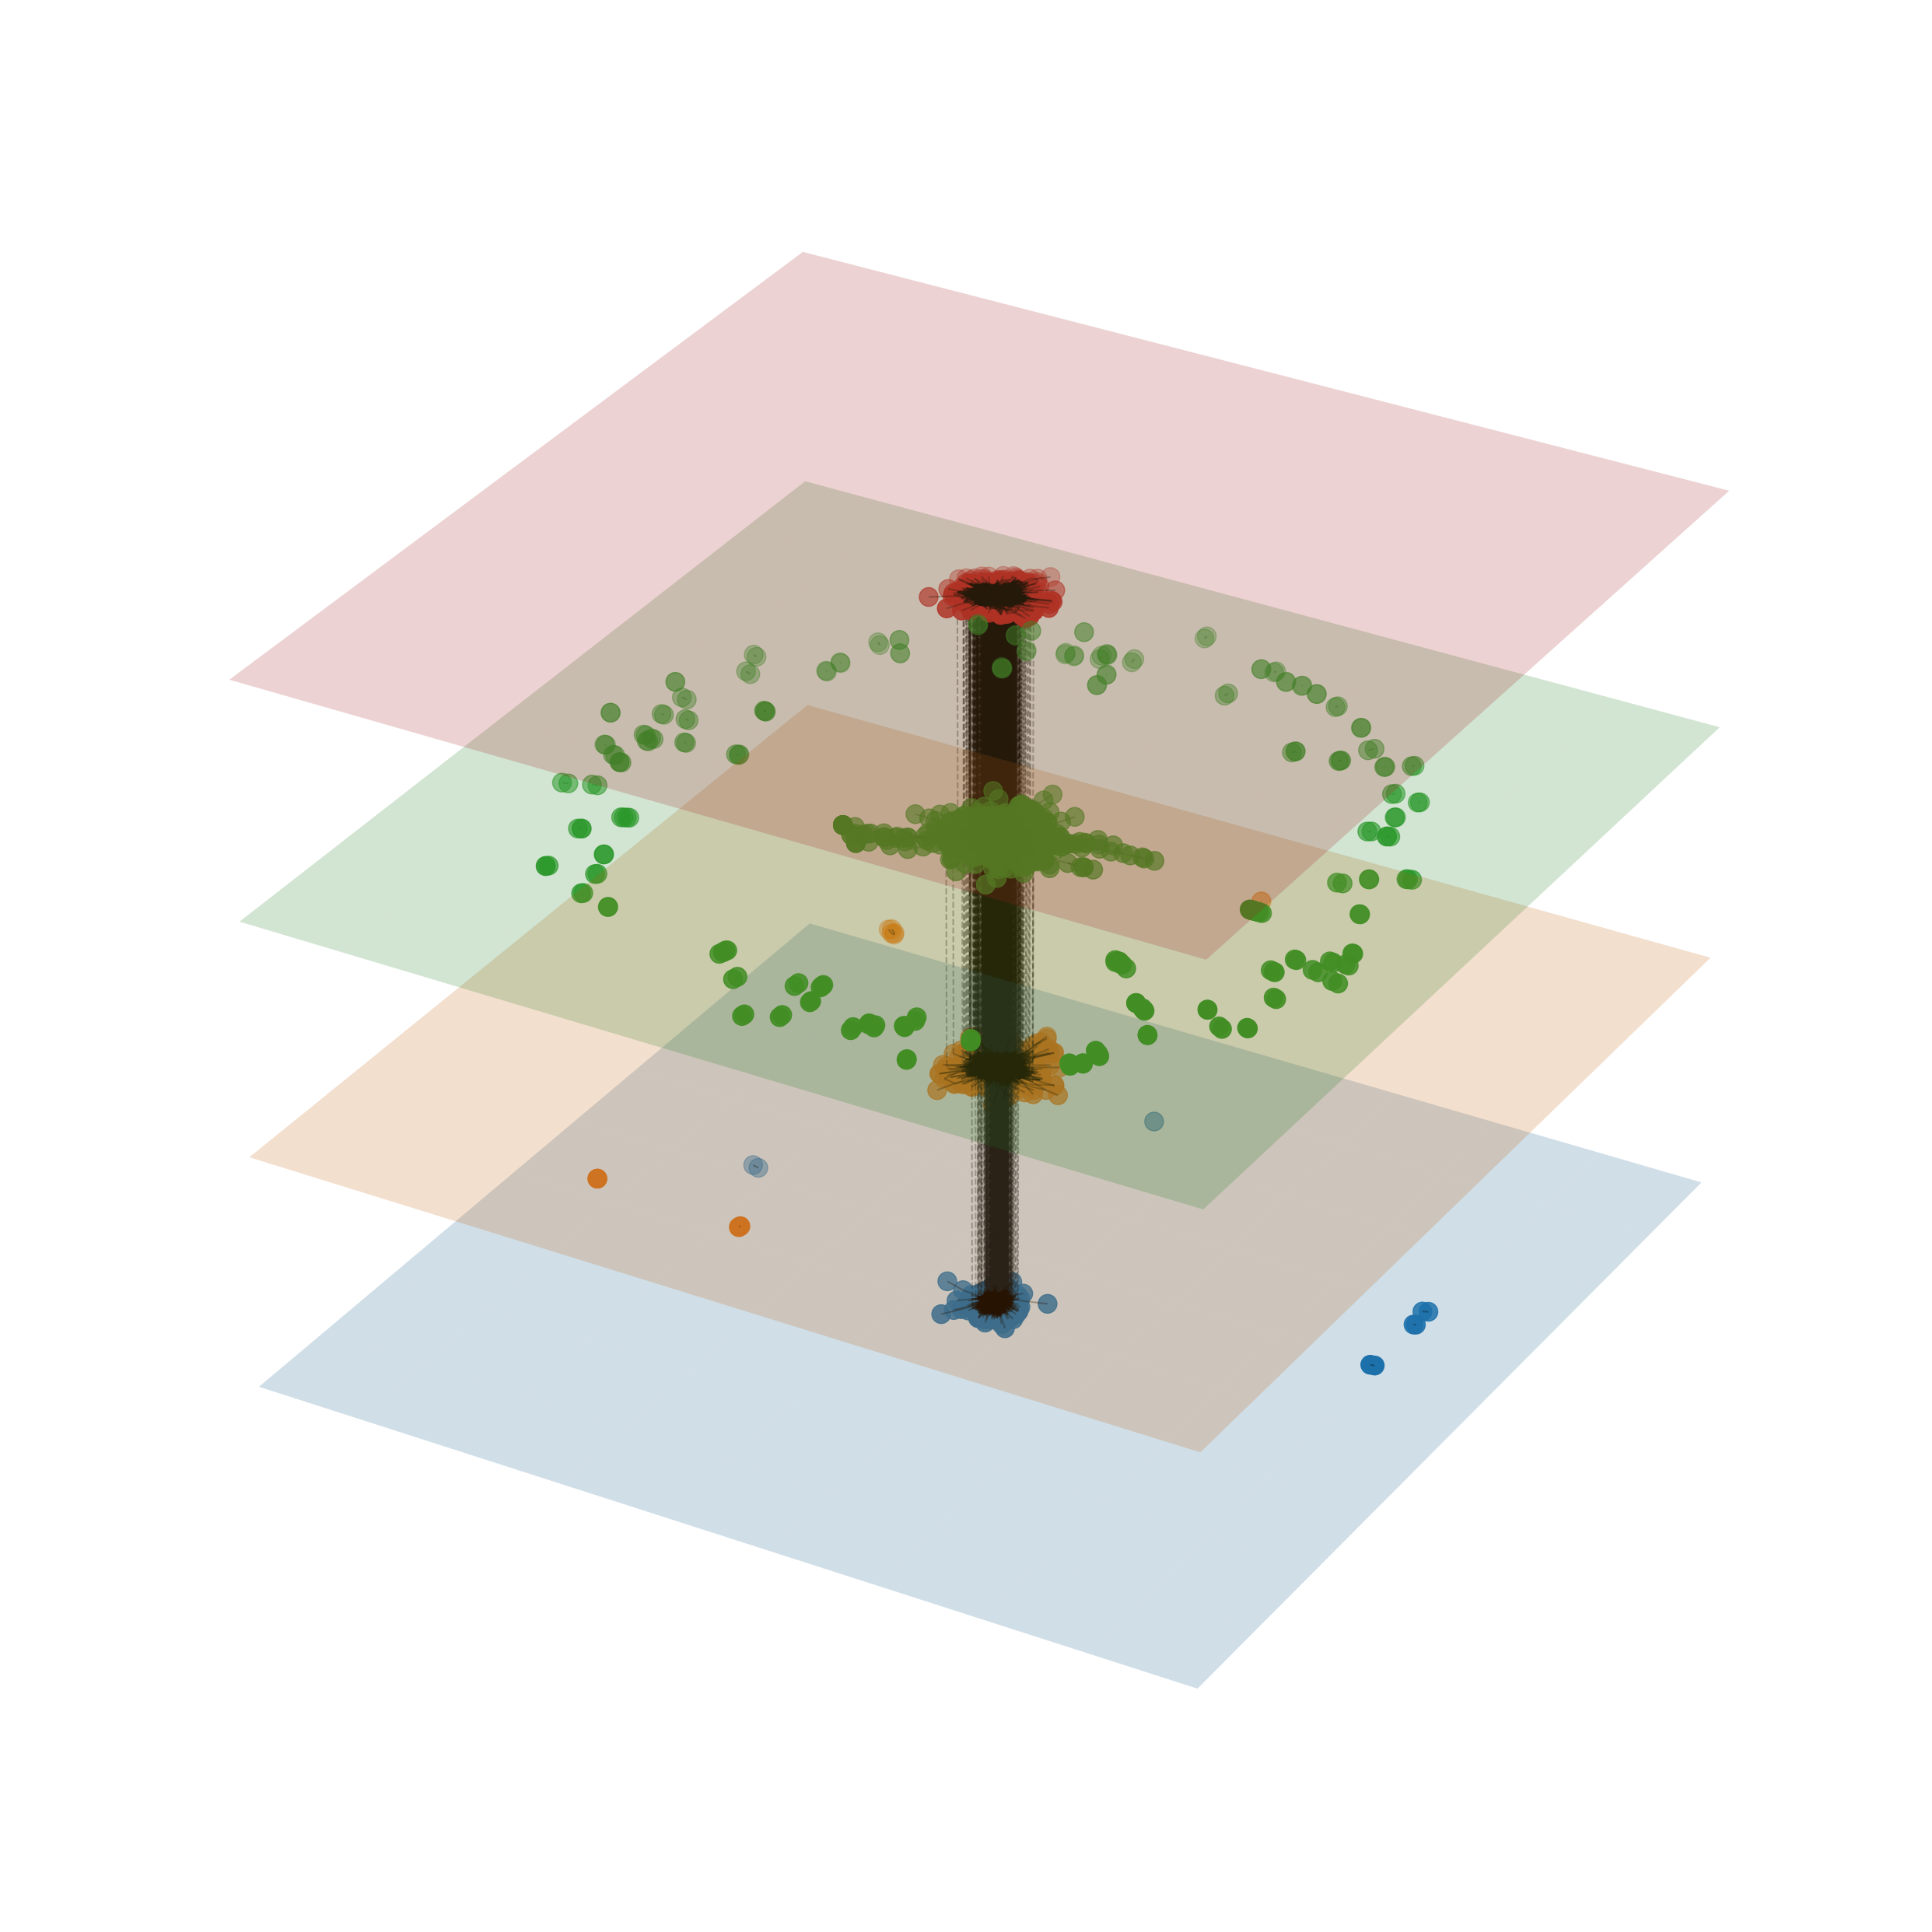

In [25]:

# define graphs
graph_layers = [visual_layer_nx, free_association_layer_nx, bert_layer_nx, lancaster_layer_nx]


node_labels = None
figsize = (40,32)
# initialise figure and plot
fig = plt.figure(figsize=(figsize))
ax = fig.add_subplot(111, projection='3d')
LayeredNetworkGraph(graph_layers, node_labels=node_labels, ax=ax, layout=nx.spring_layout)
ax.set_axis_off()
plt.show()

In [26]:
import pickle
with open("networkx_graphs/full_adult_intersect_bert_90_cos_thresh_nx_weighted_12-14_05:42.pickle", "rb") as input_file:
    multiplex_graph = pickle.load(input_file)

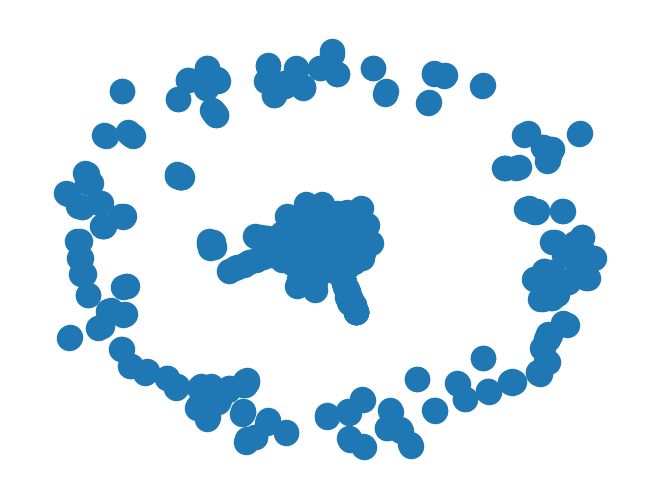

In [27]:
import networkx as nx
import matplotlib.pyplot as plt


colors = nx.get_edge_attributes(multiplex_graph,'color').values()
weights = nx.get_edge_attributes(multiplex_graph,'weight').values()

nx.draw(multiplex_graph, edge_color=colors, width=list(weights))

plt.show()

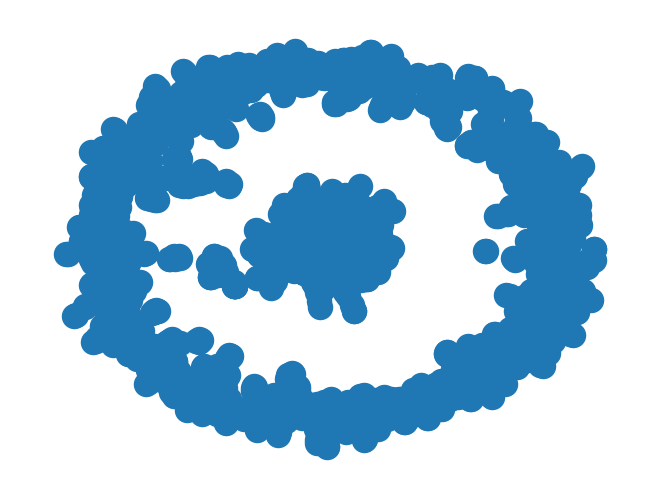

In [8]:
colors = nx.get_edge_attributes(bert_layer_nx,'color').values()
weights = nx.get_edge_attributes(bert_layer_nx,'weight').values()

nx.draw(bert_layer_nx, edge_color=colors, width=list(weights))

plt.show()

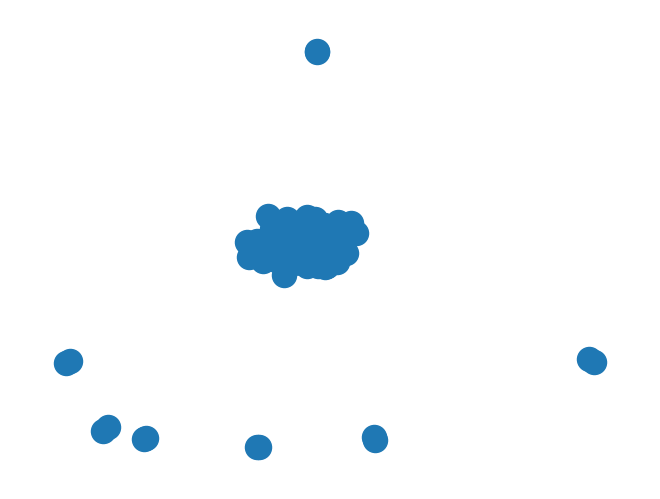

In [9]:
colors = nx.get_edge_attributes(visual_layer_nx,'color').values()
weights = nx.get_edge_attributes(visual_layer_nx,'weight').values()

nx.draw(visual_layer_nx, edge_color=colors, width=list(weights))

plt.show()

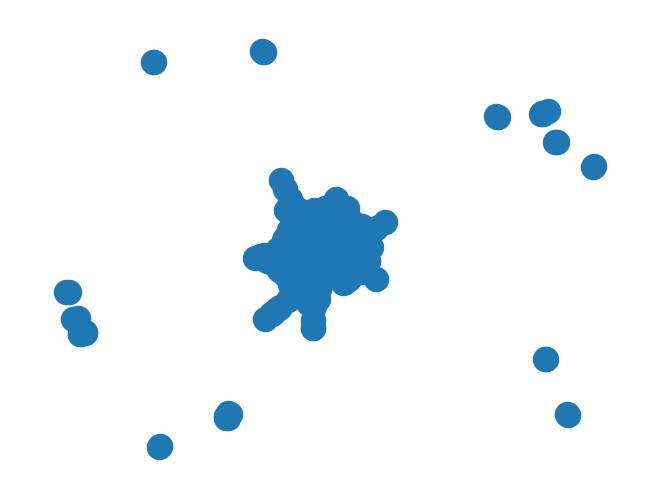

In [10]:
colors = nx.get_edge_attributes(lancaster_layer_nx,'color').values()
weights = nx.get_edge_attributes(lancaster_layer_nx,'weight').values()

nx.draw(lancaster_layer_nx, edge_color=colors, width=list(weights))

plt.show()

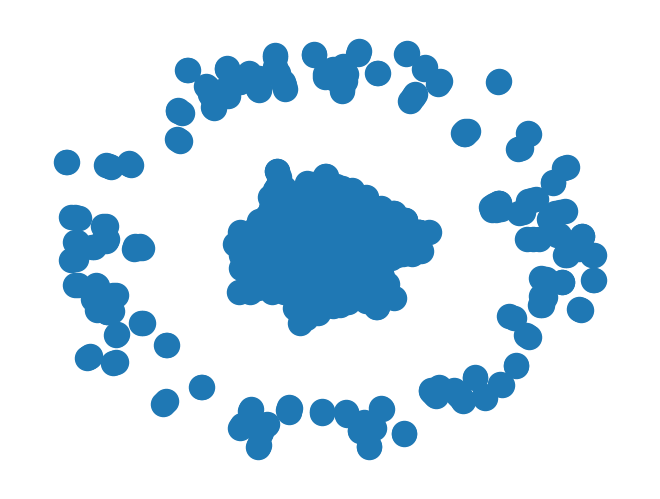

In [11]:
colors = nx.get_edge_attributes(free_association_layer_nx,'color').values()
weights = nx.get_edge_attributes(free_association_layer_nx,'weight').values()

nx.draw(free_association_layer_nx, edge_color=colors, width=list(weights))

plt.show()